# Part 2: Machine Learning

In [1]:
! pip install mne
import mne
from mne.decoding import Vectorizer, SlidingEstimator, cross_val_multiscore

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, auc, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support

# Models
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import mne.viz

import numpy as np
import copy

## Loading the data and creating train - test sets

### Exercise 1:

1. Import the same '.fif' file as in 'Part 1: About neural data', 
2. Extract the data

In [2]:
# solution
data_file = 'https://github.com/fma0/AMLD/blob/main/902-P'
data_file = '902-P'
epochs = mne.read_epochs(data_file + '.fif', verbose='error')

data = epochs.get_data()

If we want to extract the labels from the epochs object, we can take a look at epochs.events. This events obejct is a numpy array assaining to each trial a triple where the first number is the event time in samples. The second number is in most cases zero and can be ignored for this workshop. The third number is the event id, which we are most interessted in.

E.g. for the first 10 trials this would look like this:

In [3]:
epochs.events[:10]

array([[ 1001,     0,   201],
       [ 4188,     0,   201],
       [ 6428,     0,   201],
       [ 8397,     0,   201],
       [12184,     0,   201],
       [14113,     0,   201],
       [18388,     0,   201],
       [20434,     0,   201],
       [24309,     0,   201],
       [26371,     0,   201]], dtype=int32)

To check which event ID corresponds to which condtion check epochs.event_id.

In [4]:
epochs.event_id

{'Standard': 201, 'Novel': 202}

In the first line of the next shell we extract the labels. As we saw right above, they are currently set to 201 and 202. We map them to 0 and 1 in the second line of the next shell, such that the class with more trials (*Standard*, assigned 201) will now correspond to 0. 

In [5]:
labels = epochs.events[:,-1]
labels = np.where(labels == 201, 0, 1)

### Exercise 2:
How many trials are there of each condition?

In [6]:
# solution 
print(f'There are {len(np.where(labels == 0)[0])} Standard and {len(np.where(labels == 1)[0])} Novel trials')

There are 127 Standard and 27 Novel trials


We next create the train and test sets with a function from sklearn called [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). As arguments give first the data, than the labels. We also set test_size=0.2 and random_state=42

In [7]:
# solution
train_data, test_data, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, 
                                                                    random_state=42)


### Exercise 3:
What are the dimensions fo the train and test datasets?

In [8]:
# solution
print(f'The test set has a size of {test_data.shape}')
print(f'The test set has a size of {train_data.shape}')

The test set has a size of (31, 60, 301)
The test set has a size of (123, 60, 301)


## Creating a pipeline and fitting a first classifier

Next, we will construct a pipeline for classification with the function [make_pipeline()](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) of the sklearn library. We want to execute the following steps:
1. We need to transform the EEG data from (n_epochs, n_channels, n_times) to (n_samples, n_features), as the classifier that we are going to use here is working with two dimensional input. This can be achieved with the [Vectorizer()](https://mne.tools/stable/generated/mne.decoding.Vectorizer.html) function of mne.
2. Standardize our data, to compensate for differences in power of the EEG. I.e. we substract the mean ($\mu$) from our original data ($x$) and devide by the standard deviation ($\sigma$) to get the standardized data $z$: $z = (x - \mu) / \sigma$. 

    This can be achieved with the [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) function of mne. 

3. The last step will be the machine learning algorithm used for classification. We will use [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit), with C=1 and penalty='l2. 


The final pipeline will look like this (where the order of functions again is very important):

In [9]:
clf = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(solver='liblinear', random_state=42, 
                                                                       penalty='l2', C=1))

Now we have everythin ready and can fit our classifier with the training data:

In [10]:
clf.fit(train_data, labels_train)

Pipeline(steps=[('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x7fee695e6910>),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, random_state=42, solver='liblinear'))])

After training the classifier we evaluate the performance, first on the train set, by calculating the predicted labels for the train_data and then the [accuracy](accuracy_score) with the function from sklearn.metrics

In [11]:
predictions = clf.predict(train_data)
print(accuracy_score(labels_train, predictions))

1.0


But it is easier, to use the function from sklearn to directly get the score

In [12]:
clf.score(train_data, labels_train)

1.0

### Exercise 4: 
The score for the train set is quite amazing. What is the classification score on the test dataset? 

In [13]:
# solution
clf.score(test_data, labels_test)

0.4838709677419355

As it was mentioned in the lecture, it is not very good to only do this once, on a single split of the data. So we would need to do the data spliting, fitting the classifers and evaluation multiple times. 
In stead we can also use a function from sklearn called [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) on the full data and labels, which does split the data multiple times (the number is given with the cv parameter) and calculates the scores automatically

In [14]:
clf_cv = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(solver='liblinear', 
                                                                          random_state=42, 
                                                                          penalty='l2', C=1))
scores = cross_val_score(clf_cv, train_data, labels_train, cv=5)
for i in range(len(scores)):   
    print(f'Accuracy of {i}th fold is {scores[i] : .2f}\n')

Accuracy of 0th fold is  0.60

Accuracy of 1th fold is  0.68

Accuracy of 2th fold is  0.64

Accuracy of 3th fold is  0.46

Accuracy of 4th fold is  0.54



## Optimizing the classifier

In the above paradigm we just used a default implementation of Logistic Regression with a 'l2' metric and a hyperparameter C set to 1. Now we will estimate the parameters through exhaustive [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), these parameters are oftentimes called hyperparameters.

'GridSearchCV' exhaustively tests candidate models from a grid of parameter values specified in the following form:

In [15]:
parameters = {'penalty' : ['l1', 'l2'], 'C' : [1, 10, 100]}

We include the Grid Search in the pipeline, in stead of Logistic Regression. The GridSearch object will take the classifier as an argument. And as you can see we also give again the cv argument, such that the parameters above can be evaluated on multiple different splits. 

In [16]:
clf_opt = make_pipeline(Vectorizer(), StandardScaler(), GridSearchCV(LogisticRegression(solver='liblinear', 
                                                                                        random_state=42), 
                                                                     parameters, cv=5))

In [17]:
clf_opt.fit(train_data, labels_train)

Pipeline(steps=[('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x7fee6b0dc6d0>),
                ('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(random_state=42,
                                                           solver='liblinear'),
                              param_grid={'C': [1, 10, 100],
                                          'penalty': ['l1', 'l2']}))])

As before we can asses the performance of the train set with:

In [18]:
clf_opt.score(train_data, labels_train)

1.0

### Exercise 5:
What is the performance of the optimized classifier on the test set? Is this better then the one we used before?

In [19]:
clf_opt.score(test_data, labels_test)

0.8064516129032258

We can extract the optimized parameters through:

In [20]:
tmp = clf_opt.steps[-1][1]
tmp.best_params_

{'C': 1, 'penalty': 'l1'}

Please note, that this is only working on a classifier trained specifically. You can not extract the best parameters from the cross_val_score function.

## A short note on Bias

What is the level of chance for the data that we are using?

*Standard* has 127 trials and *Novel* has 27, which means that for a classifier always predicting *Standard* we get an accuracy of 127/(127+27) = 0.82! Which is around the same level, as the test score in Exercise 5.

This means that for some cases, where we have extreamly unbalanced datasets, using accuracy to keep track of your performance is not an appropriate choice. We could for example use the [f1-score](https://en.wikipedia.org/wiki/F-score). For the above naive classifier, that always predicts *Standard*, the f1-score would be 0.

Let's check out the f1-score of our classifer:

In [21]:
prediction = clf_opt.predict(train_data)

f1_score(labels_train, prediction)

1.0

### Exercise 6:
What is the f1-score of the optimized classifier on the test set?

In [22]:
# solution
prediction = clf_opt.predict(test_data)

f1_score(labels_test, prediction)

0.4

## Sliding Estimator

In the steps above we were still evaluating a rather simplified version of our data, where we did not considered the temporal structure of EEG data. But considered all time points and electrodes simultaneously.  Now we will take the temporal dimension into account as well and will evaluate how classification accuracy changes across time. For this we will use the [SlidingEstimator](https://mne.tools/stable/generated/mne.decoding.SlidingEstimator.html) of mne:

In [23]:
clf_tp = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(solver='liblinear', 
                                                                          random_state=42, penalty='l1', 
                                                                          C=1))

sl = SlidingEstimator(clf_tp, scoring=make_scorer(f1_score)) # we apply the sliding estimator to 'clf'
sl.fit(train_data, labels_train)

<SlidingEstimator(base_estimator=Pipeline(steps=[('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x7fee52a527d0>),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='liblinear'))]),
         n_jobs=1, scoring=make_scorer(f1_score), verbose=None, fitted with 301 estimators>

In [24]:
score_train = sl.score(train_data, labels_train)
score_test = sl.score(test_data, labels_test)

### Exercise 7:
What are the dimensions of the classification scores? What do they represent?

In [25]:
# solution
print(f'The scores now have the shape {score_test.shape}, which represents a score per time point')

The scores now have the shape (301,), which represents a score per time point


We can now plot the classification accuracies across time:

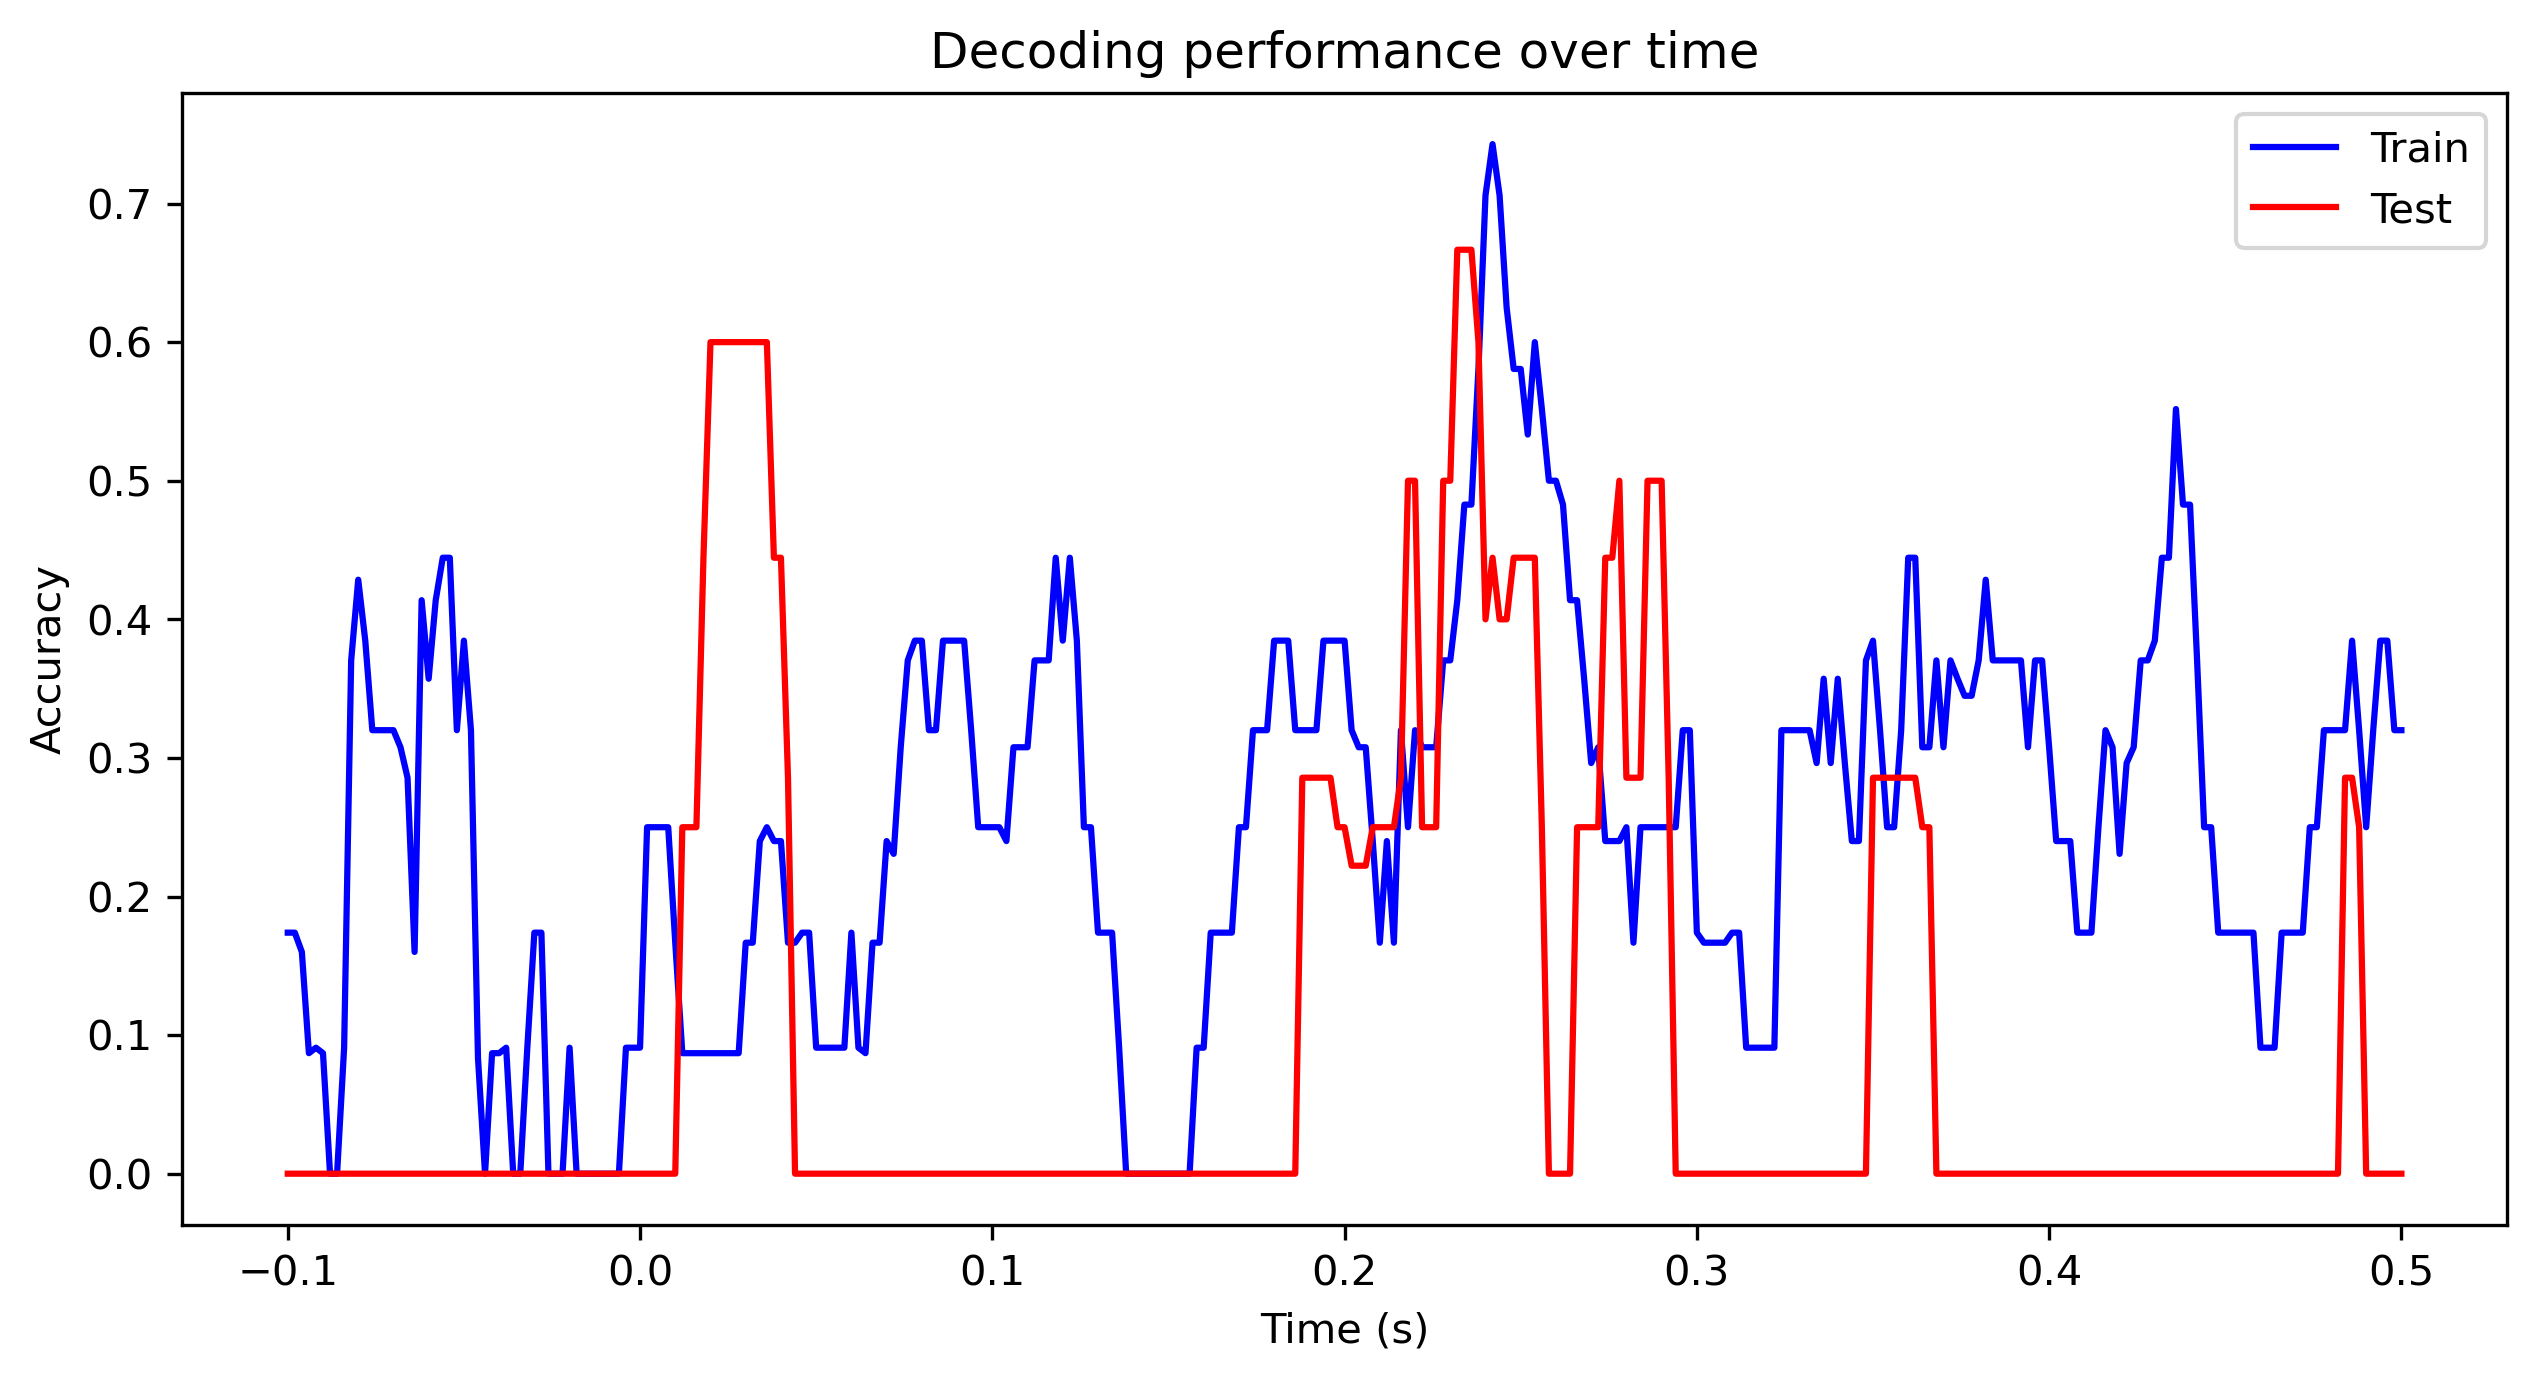

In [26]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accuracy') 
ax.set_title('Decoding performance over time')
ax.plot(epochs.times, score_train, color='blue', label='Train')
ax.plot(epochs.times, score_test, color='red', label='Test')
ax.legend()
plt.show()

### Extracting the weights
From each classifier we can extract the weights, representing how importent each electrode / time point is for the classification performance. The weights can be found as estimator.coef_ for all of the classifiers that we used above. 

In this example here, we will look at the Sliding Estimator classifers and extract the weights for the elextrodes per timepoint. Similar to the last part of the previous Jupyter notebook, we also copy the evoked structure, to asign the weights and plot them.

In [27]:
times = epochs.times

weights = copy.deepcopy(epochs.average())
for tp in range(len(times)):
    weights._data[:,tp] = sl.estimators_[tp].steps[-1][1].coef_

### Exercise 8:
Plot the weights in a topographic map representation (see 'Part 1: About neural data') for the following timepoints:

In [28]:
timepoints = np.arange(0, 0.51, 0.1)

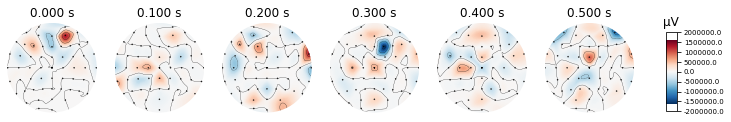

In [29]:
# solution
weights.plot_topomap(timepoints, ch_type='eeg');